In [22]:
import gdown
import zipfile

# The Google Drive file ID and download URL
file_id = "1ItYitzgHV1N1NzyA7oRk20wyNBJsxHCI"
file_id_2 = "1DxEguWmRgZr1RDz82NyPjNHVANfsVvqs"
url = f"https://drive.google.com/uc?id={file_id}"
url2 = f"https://drive.google.com/uc?id={file_id_2}"


# The output file name
output = "Audio_Speech_Actors_01-24.zip"
output2 = "Audio_Song_Actors_01-24.zip"

# Download the file
gdown.download(url, output, quiet=False)
#gdown.download(url2, output2, quiet=False)

# Optionally, extract the zip file
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("Audio_Speech_Actors_01-24")

#with zipfile.ZipFile(output2, 'r') as zip_ref:
 #   zip_ref.extractall("Audio_Song_Actors_01-24")

print("Download and extraction completed!")


Downloading...
From (original): https://drive.google.com/uc?id=1ItYitzgHV1N1NzyA7oRk20wyNBJsxHCI
From (redirected): https://drive.google.com/uc?id=1ItYitzgHV1N1NzyA7oRk20wyNBJsxHCI&confirm=t&uuid=c154b463-2ce5-496e-b214-bb870b7592a8
To: /content/Audio_Speech_Actors_01-24.zip
100%|██████████| 208M/208M [00:01<00:00, 119MB/s]


Download and extraction completed!


### Spliting training and testing data

In [23]:
import os
import csv
import re
from sklearn.model_selection import train_test_split

# Base directory containing the extracted audio files
BASE_DIR = "Audio_Speech_Actors_01-24"

# List to hold information about each audio file
data = []

# Function to parse the filename based on the expected 7-part naming convention
def parse_filename(filename, folder_path):
    # Remove file extension
    name = os.path.splitext(filename)[0]
    parts = name.split("-")

    # Check if the filename splits into exactly 7 parts
    if len(parts) == 7:
        modality, vocal_channel, emotion, intensity, statement, repetition, actor = parts
    else:
        # If the naming convention isn't followed, set all fields to None
        modality = vocal_channel = emotion = intensity = statement = repetition = actor = None

    # Determine gender from actor id (based on RAVDESS convention: odd = male, even = female)
    try:
        actor_num = int(actor)
        gender = "Female" if actor_num % 2 == 0 else "Male"
    except Exception:
        gender = None

    return {
        "modality": modality,
        "vocal_channel": vocal_channel,
        "emotion": emotion,
        "intensity": intensity,
        "statement": statement,
        "repetition": repetition,
        "actor": actor,
        "gender": gender
    }

# Walk through the BASE_DIR and process each .wav file
for root, dirs, files in os.walk(BASE_DIR):
    for file in files:
        if file.lower().endswith(".wav"):
            filepath = os.path.join(root, file)
            labels = parse_filename(file, root)
            labels["filepath"] = filepath
            data.append(labels)

# Check if all files have corresponding valid labels
invalid_files = []
for item in data:
    # Check for any required field being None
    required_keys = ["modality", "vocal_channel", "emotion", "intensity", "statement", "repetition", "actor"]
    if not all(item.get(key) is not None for key in required_keys):
        invalid_files.append(item["filepath"])

if invalid_files:
    print("Warning: The following files did not follow the 7-part naming convention and have missing labels:")
    for f in invalid_files:
        print(f"  {f}")
    print(f"\nTotal files with missing labels: {len(invalid_files)} out of {len(data)}")
else:
    print("All files have valid corresponding labels.")

# Define the order of columns for CSV output
fieldnames = ["filepath", "modality", "vocal_channel", "emotion", "intensity", "statement", "repetition", "actor", "gender"]

# Write all file labels to a CSV file
with open("ravdess_labels.csv", "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in data:
        writer.writerow(row)

print(f"Total files processed: {len(data)}")
print("Label file 'ravdess_labels.csv' has been created.")

# Split the data into training and testing sets (e.g., 80% train, 20% test)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=89)

# Write training set labels to CSV
with open("train_labels.csv", "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in train_data:
        writer.writerow(row)

# Write testing set labels to CSV
with open("test_labels.csv", "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in test_data:
        writer.writerow(row)

print("Train/Test split complete. 'train_labels.csv' and 'test_labels.csv' have been created.")


All files have valid corresponding labels.
Total files processed: 1440
Label file 'ravdess_labels.csv' has been created.
Train/Test split complete. 'train_labels.csv' and 'test_labels.csv' have been created.


### Fine-Tuning the gender agnostic model

All Param Combinations:  22%|██▏       | 2/9 [03:52<13:37, 116.75s/it]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

🎯 Performance Comparison by Group:
   group classifier  test_accuracy  cv_accuracy  sample_rate  orb_features  \
22   All        SVM       0.369444     0.335185        22050           500   
19   All        SVM       0.355556     0.323148        22050           500   
7    All        SVM       0.352778     0.313889        22050           300   
13   All        SVM       0.350000     0.312037        22050           400   
25   All        SVM       0.350000     0.337963        22050           500   
..   ...        ...            ...          ...          ...           ...   
38  Male        KNN       0.251397     0.231082        22050           400   
35  Male        KNN       0.245810     0.234684        22050           300   
53  Male        KNN       0.240223     0.262462        22050           500   
47  Male        KNN       0.223464     0.247678        22050           500   
32  Male        KNN       0.189944     0.240291        22050           300   

    n_clusters              

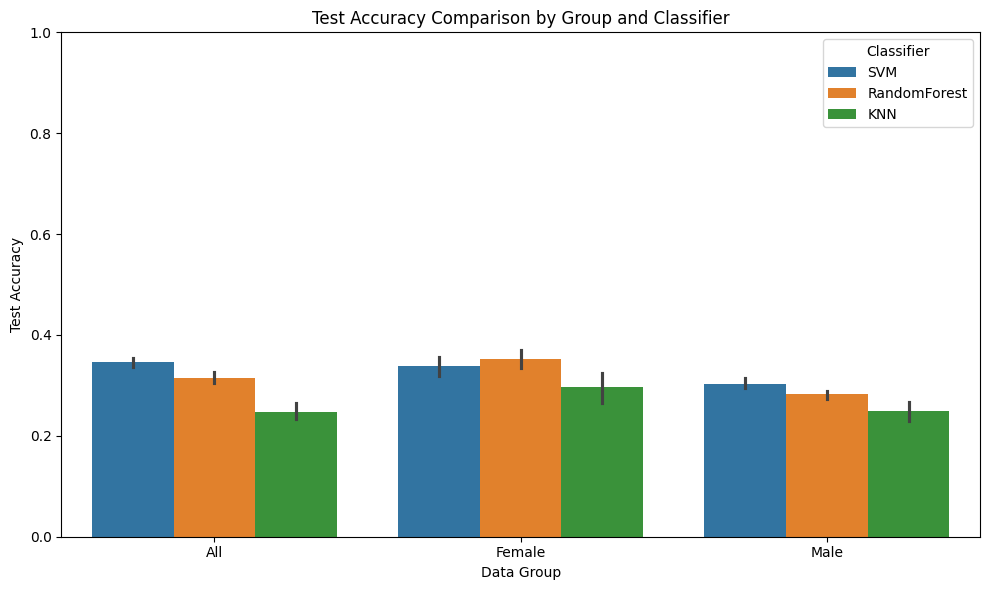

In [ ]:
import os
import numpy as np
import cv2
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from itertools import product
from tqdm import tqdm

####################################
# Helper Functions (Feature Engineering)
####################################

def generate_spectrogram_image(audio_path, sample_rate):
    y, sr = librosa.load(audio_path, sr=sample_rate)
    S = np.abs(librosa.stft(y))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    img = 255 * (S_db - S_db.min()) / (S_db.max() - S_db.min())
    return img.astype(np.uint8)

def extract_orb_descriptors(image, orb_detector):
    keypoints, descriptors = orb_detector.detectAndCompute(image, None)
    return descriptors

def build_codebook(descriptor_list, n_clusters):
    descriptors = np.vstack(descriptor_list)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(descriptors)
    return kmeans

def compute_bovw_histogram(descriptors, kmeans, n_clusters):
    if descriptors is None:
        return np.zeros(n_clusters)
    cluster_indices = kmeans.predict(descriptors)
    hist, _ = np.histogram(cluster_indices, bins=np.arange(n_clusters+1))
    if hist.sum() > 0:
        hist = hist / hist.sum()  # L1 normalization
    return hist

####################################
# Main BoVW + Classification Pipeline Function
####################################

def run_pipeline(train_df, test_df, classifiers, sample_rates, orb_features_list, cluster_numbers, label="All"):
    results = []
    param_combinations = list(product(sample_rates, orb_features_list, cluster_numbers))

    for sample_rate, orb_n_features, n_clusters in tqdm(param_combinations, total=len(param_combinations), desc=f"{label} Param Combinations"):
        orb = cv2.ORB_create(nfeatures=orb_n_features)

        train_descriptor_list = []
        train_descriptors_per_file = []
        train_labels_processed = []

        for _, row in train_df.iterrows():
            audio_path = row['filepath']
            if not os.path.exists(audio_path): continue
            try:
                spec_img = generate_spectrogram_image(audio_path, sample_rate)
                descriptors = extract_orb_descriptors(spec_img, orb)
                if descriptors is not None and len(descriptors) > 0:
                    train_descriptor_list.append(descriptors)
                train_descriptors_per_file.append(descriptors)
                train_labels_processed.append(row['emotion'])
            except:
                continue

        if len(train_descriptor_list) == 0:
            continue

        try:
            kmeans = build_codebook(train_descriptor_list, n_clusters)
        except:
            continue

        train_histograms = [compute_bovw_histogram(d, kmeans, n_clusters) for d in train_descriptors_per_file]
        train_histograms = np.array(train_histograms)
        train_labels_processed = np.array(train_labels_processed)

        # Test set
        test_histograms = []
        test_labels_processed = []
        for _, row in test_df.iterrows():
            audio_path = row['filepath']
            if not os.path.exists(audio_path): continue
            try:
                spec_img = generate_spectrogram_image(audio_path, sample_rate)
                descriptors = extract_orb_descriptors(spec_img, orb)
                hist = compute_bovw_histogram(descriptors, kmeans, n_clusters)
                test_histograms.append(hist)
                test_labels_processed.append(row['emotion'])
            except:
                continue

        test_histograms = np.array(test_histograms)
        test_labels_processed = np.array(test_labels_processed)

        scaler = StandardScaler()
        train_scaled = scaler.fit_transform(train_histograms)
        test_scaled = scaler.transform(test_histograms)

        for clf_name, clf_info in classifiers.items():
            estimator = clf_info['estimator']
            param_grid = clf_info['param_grid']
            grid = GridSearchCV(estimator, param_grid, cv=3, scoring='accuracy')
            try:
                grid.fit(train_scaled, train_labels_processed)
            except:
                continue

            preds = grid.predict(test_scaled)
            results.append({
                "group": label,
                "classifier": clf_name,
                "sample_rate": sample_rate,
                "orb_features": orb_n_features,
                "n_clusters": n_clusters,
                "best_params": grid.best_params_,
                "cv_accuracy": grid.best_score_,
                "test_accuracy": accuracy_score(test_labels_processed, preds),
                "report": classification_report(test_labels_processed, preds, output_dict=True)
            })

    return results

####################################
# Classifier Configurations
####################################

classifiers = {
    'RandomForest': {
        'estimator': RandomForestClassifier(random_state=42),
        'param_grid': {'n_estimators': [500, 1000], 'max_depth': [None, 10]}
    },
    'SVM': {
        'estimator': SVC(random_state=42),
        'param_grid': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    },
    'KNN': {
        'estimator': KNeighborsClassifier(),
        'param_grid': {'n_neighbors': [3, 5, 7]}
    }
}

# Parameter grid for feature extraction
sample_rates = [22050]
orb_features_list = [300, 400, 500]
cluster_numbers = [30, 40, 50]

####################################
# Load Data and Split by Gender
####################################

train_df = pd.read_csv("train_labels.csv")
test_df = pd.read_csv("test_labels.csv")

train_male = train_df[train_df['gender'] == 'Male']
test_male = test_df[test_df['gender'] == 'Male']

train_female = train_df[train_df['gender'] == 'Female']
test_female = test_df[test_df['gender'] == 'Female']

####################################
# Run Experiments for All Groups
####################################

results_all = run_pipeline(train_df, test_df, classifiers, sample_rates, orb_features_list, cluster_numbers, label="All")
results_male = run_pipeline(train_male, test_male, classifiers, sample_rates, orb_features_list, cluster_numbers, label="Male")
results_female = run_pipeline(train_female, test_female, classifiers, sample_rates, orb_features_list, cluster_numbers, label="Female")

####################################
# Combine and Compare Results
####################################

all_results = results_all + results_male + results_female
results_df = pd.DataFrame(all_results)
results_df_sorted = results_df.sort_values(by=["group", "test_accuracy"], ascending=[True, False])

print("🎯 Performance Comparison by Group:")
print(results_df_sorted[["group", "classifier", "test_accuracy", "cv_accuracy", "sample_rate", "orb_features", "n_clusters", "best_params"]])

####################################
# Optional: Visualize Comparison
####################################

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df_sorted, x="group", y="test_accuracy", hue="classifier")
plt.title("Test Accuracy Comparison by Group and Classifier")
plt.ylabel("Test Accuracy")
plt.xlabel("Data Group")
plt.ylim(0, 1)
plt.legend(title="Classifier")
plt.tight_layout()
plt.show()


In [24]:
import os
import csv
import numpy as np
import cv2
import librosa
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from itertools import product
from tqdm import tqdm

####################################
# Helper Functions (Feature Engineering)
####################################

def generate_spectrogram_image(audio_path, sample_rate):
    """
    Load audio using Librosa at the specified sample rate, compute its STFT,
    convert the amplitude to dB, and normalize the spectrogram to 8-bit grayscale.
    """
    y, sr = librosa.load(audio_path, sr=sample_rate)
    S = np.abs(librosa.stft(y))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    # Normalize to 0-255
    img = 255 * (S_db - S_db.min()) / (S_db.max() - S_db.min())
    return img.astype(np.uint8)

def extract_orb_descriptors(image, orb_detector):
    """
    Use ORB to detect keypoints and compute descriptors from the image.
    """
    keypoints, descriptors = orb_detector.detectAndCompute(image, None)
    return descriptors

def build_codebook(descriptor_list, n_clusters):
    """
    Stack all ORB descriptors and perform K-means clustering to build a visual dictionary.
    """
    descriptors = np.vstack(descriptor_list)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(descriptors)
    return kmeans

def compute_bovw_histogram(descriptors, kmeans, n_clusters):
    """
    Assign each descriptor to the nearest cluster centroid and build a normalized histogram.
    """
    if descriptors is None:
        return np.zeros(n_clusters)
    cluster_indices = kmeans.predict(descriptors)
    hist, _ = np.histogram(cluster_indices, bins=np.arange(n_clusters+1))
    if hist.sum() > 0:
        hist = hist / hist.sum()  # L1 normalization
    return hist

####################################
# Load Train/Test Labels (assumes these CSV files already exist)
####################################
train_df = pd.read_csv("train_labels.csv")
test_df = pd.read_csv("test_labels.csv")

####################################
# Parameter Grid for Feature Extraction
####################################
sample_rates = [22050]                      # You can add 11025, 44100 if needed
orb_features_list = [300, 400, 500]           # Experiment with number of ORB features
cluster_numbers = [30, 40, 50]                # Experiment with number of clusters

# Prepare to store overall results
all_results = []
param_combinations = list(product(sample_rates, orb_features_list, cluster_numbers))
total_combinations = len(param_combinations)

# Define classifiers and their parameter grids
classifiers = {
    'RandomForest': {
        'estimator': RandomForestClassifier(random_state=42),
        'param_grid': {'n_estimators': [500, 1000], 'max_depth': [None, 10]}
    },
    'SVM': {
        'estimator': SVC(random_state=42),
        'param_grid': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    },
    'KNN': {
        'estimator': KNeighborsClassifier(),
        'param_grid': {'n_neighbors': [3, 5, 7]}
    }
}

####################################
# Loop through all parameter combinations with progress bar
####################################
for sample_rate, orb_n_features, n_clusters in tqdm(param_combinations, total=total_combinations, desc="Param Combinations"):
    # Initialize ORB detector with current number of features
    orb = cv2.ORB_create(nfeatures=orb_n_features)

    # --- Process Training Set ---
    train_descriptor_list = []        # For codebook construction
    train_descriptors_per_file = []     # For each file's descriptors
    train_labels_processed = []         # Labels for each training file

    for idx, row in train_df.iterrows():
        audio_path = row['filepath']
        if not os.path.exists(audio_path):
            continue
        spec_img = generate_spectrogram_image(audio_path, sample_rate=sample_rate)
        descriptors = extract_orb_descriptors(spec_img, orb)
        if descriptors is not None and len(descriptors) > 0:
            train_descriptor_list.append(descriptors)
        train_descriptors_per_file.append(descriptors)
        train_labels_processed.append(row['emotion'])

    # If no descriptors were extracted for this combination, skip it
    if len(train_descriptor_list) == 0:
        continue

    try:
        # Build visual dictionary (codebook) using K-means clustering
        kmeans = build_codebook(train_descriptor_list, n_clusters=n_clusters)
    except Exception as e:
        continue

    # Convert each training file's descriptors into a histogram
    train_histograms = []
    for descriptors in train_descriptors_per_file:
        hist = compute_bovw_histogram(descriptors, kmeans, n_clusters=n_clusters)
        train_histograms.append(hist)
    train_histograms = np.array(train_histograms)
    train_labels_processed = np.array(train_labels_processed)

    # --- Process Test Set ---
    test_histograms = []
    test_labels_processed = []
    for idx, row in test_df.iterrows():
        audio_path = row['filepath']
        if not os.path.exists(audio_path):
            continue
        spec_img = generate_spectrogram_image(audio_path, sample_rate=sample_rate)
        descriptors = extract_orb_descriptors(spec_img, orb)
        hist = compute_bovw_histogram(descriptors, kmeans, n_clusters=n_clusters)
        test_histograms.append(hist)
        test_labels_processed.append(row['emotion'])
    test_histograms = np.array(test_histograms)
    test_labels_processed = np.array(test_labels_processed)

    # Standardize the feature vectors
    scaler = StandardScaler()
    train_histograms_scaled = scaler.fit_transform(train_histograms)
    test_histograms_scaled = scaler.transform(test_histograms)

    # For each classifier, perform GridSearchCV and evaluate results
    for clf_name, clf_info in classifiers.items():
        estimator = clf_info['estimator']
        param_grid = clf_info['param_grid']
        grid_cv = GridSearchCV(estimator, param_grid, cv=3, scoring='accuracy')
        try:
            grid_cv.fit(train_histograms_scaled, train_labels_processed)
        except Exception as e:
            continue
        best_params = grid_cv.best_params_
        cv_accuracy = grid_cv.best_score_

        predictions = grid_cv.predict(test_histograms_scaled)
        test_accuracy = accuracy_score(test_labels_processed, predictions)

        # Store results with current feature extraction parameters and classifier details
        all_results.append({
            "classifier": clf_name,
            "sample_rate": sample_rate,
            "orb_features": orb_n_features,
            "n_clusters": n_clusters,
            "best_params": best_params,
            "cv_accuracy": cv_accuracy,
            "test_accuracy": test_accuracy
        })

####################################
# Display and Compare Results
####################################
results_df = pd.DataFrame(all_results)
results_df_sorted = results_df.sort_values(by="test_accuracy", ascending=False)
print("Results for all parameter combinations and classifiers:")
print(results_df_sorted)


Param Combinations:   0%|          | 0/9 [00:13<?, ?it/s]


KeyboardInterrupt: 

### Comparing Gender Agnostic and Male-Female Models

##### Imports and Helper Functions

In [25]:
import os
import numpy as np
import cv2
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             f1_score, precision_score, recall_score)
from sklearn.svm import SVC
from itertools import product
from tqdm import tqdm

####################################
# Helper Functions (Feature Engineering)
####################################

def generate_spectrogram_image(audio_path, sample_rate):
    y, sr = librosa.load(audio_path, sr=sample_rate)
    S = np.abs(librosa.stft(y))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    img = 255 * (S_db - S_db.min()) / (S_db.max() - S_db.min())
    return img.astype(np.uint8)

def extract_orb_descriptors(image, orb_detector):
    keypoints, descriptors = orb_detector.detectAndCompute(image, None)
    return descriptors

def build_codebook(descriptor_list, n_clusters):
    descriptors = np.vstack(descriptor_list)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(descriptors)
    return kmeans

def compute_bovw_histogram(descriptors, kmeans, n_clusters):
    if descriptors is None:
        return np.zeros(n_clusters)
    cluster_indices = kmeans.predict(descriptors)
    hist, _ = np.histogram(cluster_indices, bins=np.arange(n_clusters+1))
    if hist.sum() > 0:
        hist = hist / hist.sum()  # L1 normalization
    return hist


##### Main Pipeline function

In [26]:
####################################
# Main BoVW + Classification Pipeline Function (Modified)
####################################
from sklearn.metrics import brier_score_loss


def run_pipeline(train_df, test_df, classifiers, sample_rates, orb_features_list, cluster_numbers, label="All"):
    results = []
    # Only one combination will exist given our fixed parameter lists.
    param_combinations = list(product(sample_rates, orb_features_list, cluster_numbers))

    for sample_rate, orb_n_features, n_clusters in tqdm(param_combinations, total=len(param_combinations), desc=f"{label} Param Combinations"):
        orb = cv2.ORB_create(nfeatures=orb_n_features)

        train_descriptor_list = []
        train_descriptors_per_file = []
        train_labels_processed = []

        for _, row in train_df.iterrows():
            audio_path = row['filepath']
            if not os.path.exists(audio_path):
                continue
            try:
                spec_img = generate_spectrogram_image(audio_path, sample_rate)
                descriptors = extract_orb_descriptors(spec_img, orb)
                if descriptors is not None and len(descriptors) > 0:
                    train_descriptor_list.append(descriptors)
                train_descriptors_per_file.append(descriptors)
                train_labels_processed.append(row['emotion'])
            except Exception:
                continue

        if len(train_descriptor_list) == 0:
            continue

        try:
            kmeans = build_codebook(train_descriptor_list, n_clusters)
        except Exception:
            continue

        train_histograms = [compute_bovw_histogram(d, kmeans, n_clusters) for d in train_descriptors_per_file]
        train_histograms = np.array(train_histograms)
        train_labels_processed = np.array(train_labels_processed)

        # Process the test set
        test_histograms = []
        test_labels_processed = []
        for _, row in test_df.iterrows():
            audio_path = row['filepath']
            if not os.path.exists(audio_path):
                continue
            try:
                spec_img = generate_spectrogram_image(audio_path, sample_rate)
                descriptors = extract_orb_descriptors(spec_img, orb)
                hist = compute_bovw_histogram(descriptors, kmeans, n_clusters)
                test_histograms.append(hist)
                test_labels_processed.append(row['emotion'])
            except Exception:
                continue

        test_histograms = np.array(test_histograms)
        test_labels_processed = np.array(test_labels_processed)

        scaler = StandardScaler()
        train_scaled = scaler.fit_transform(train_histograms)
        test_scaled = scaler.transform(test_histograms)

        # For each classifier (only SVM in our case)
        for clf_name, clf_info in classifiers.items():
            estimator = clf_info['estimator']
            # Directly train the classifier with fixed parameters
            estimator.fit(train_scaled, train_labels_processed)
            preds = estimator.predict(test_scaled)
            probs = estimator.predict_proba(test_scaled)

            # Generate calibration curve for the first class as an example
            class_idx = 0
            # Create a binary label for the chosen class (one-vs-rest)
            y_true_bin = (test_labels_processed == estimator.classes_[class_idx]).astype(int)
            # Compute calibration curve data
            prob_true, prob_pred = calibration_curve(y_true_bin, probs[:, class_idx], n_bins=10)

            # Plot the calibration curve
            plt.figure(figsize=(6,6))
            plt.plot(prob_pred, prob_true, marker='o', label=f'Calibration Curve for class {estimator.classes_[class_idx]}')
            plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
            plt.xlabel('Mean predicted probability')
            plt.ylabel('Fraction of positives')
            plt.title('Calibration Curve')
            plt.legend()
            plt.show()


            # Generate a calibration score:
            # For multi-class, compute Brier score loss for each class (one-vs-rest) and average them.

            cal_scores = []
            for i, cls in enumerate(estimator.classes_):
                y_true_bin = (test_labels_processed == cls).astype(int)
                y_prob = probs[:, i]
                brier = brier_score_loss(y_true_bin, y_prob)
                cal_scores.append(brier)
            avg_cal_score = np.mean(cal_scores)

            # Save the trained model
            model_filename = f"svm_model_{sample_rate}_{orb_n_features}_{n_clusters}.pkl"
            joblib.dump(estimator, model_filename)

            # Compute additional metrics:
            cm = confusion_matrix(test_labels_processed, preds)
            classes = np.unique(np.concatenate([test_labels_processed, preds]))
            fpr_list = []
            fnr_list = []
            for i, cls in enumerate(classes):
                TP = cm[i, i]
                FP = cm[:, i].sum() - TP
                FN = cm[i, :].sum() - TP
                TN = cm.sum() - (TP + FP + FN)
                fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
                fnr = FN / (TP + FN) if (TP + FN) > 0 else 0
                fpr_list.append(fpr)
                fnr_list.append(fnr)
            macro_fpr = np.mean(fpr_list)
            macro_fnr = np.mean(fnr_list)
            macro_f1 = f1_score(test_labels_processed, preds, average='macro')
            macro_precision = precision_score(test_labels_processed, preds, average='macro')
            macro_recall = recall_score(test_labels_processed, preds, average='macro')

            # Save predicted and true label distributions (to compute fairness metrics later)
            pred_distribution = dict(pd.Series(preds).value_counts(normalize=True))
            true_distribution = dict(pd.Series(test_labels_processed).value_counts(normalize=True))

            results.append({
                "group": label,
                "classifier": clf_name,
                "sample_rate": sample_rate,
                "orb_features": orb_n_features,
                "n_clusters": n_clusters,
                "model_file": model_filename,
                "cv_accuracy": None,  # Not applicable now since no CV is done
                "test_accuracy": accuracy_score(test_labels_processed, preds),
                "f1_score": macro_f1,
                "fpr": macro_fpr,
                "fnr": macro_fnr,
                "precision": macro_precision,
                "recall": macro_recall,
                "calibration_score": avg_cal_score,
                "predicted_distribution": pred_distribution,
                "true_distribution": true_distribution,
                "report": classification_report(test_labels_processed, preds, output_dict=True)
            })

    return results


##### Classifier Configuration and Parameters

In [27]:
####################################
# Classifier Configuration (Only SVM)
####################################

from sklearn.svm import SVC

classifiers = {
    'SVM': {
        'estimator': SVC(random_state=89, C=1, kernel='rbf', probability=True)
    }
}

# Set parameters as requested
sample_rates = [22050]
orb_features_list = [500]
cluster_numbers = [40]


##### Data Loading and Splitting by Gender

In [28]:
####################################
# Load Data and Split by Gender
####################################

train_df = pd.read_csv("train_labels.csv")
test_df = pd.read_csv("test_labels.csv")

# Overall data is used as-is.
# Also split by gender:
train_male = train_df[train_df['gender'] == 'Male']
test_male = test_df[test_df['gender'] == 'Male']

train_female = train_df[train_df['gender'] == 'Female']
test_female = test_df[test_df['gender'] == 'Female']


##### Show Spectrograms for Male and Female Samples

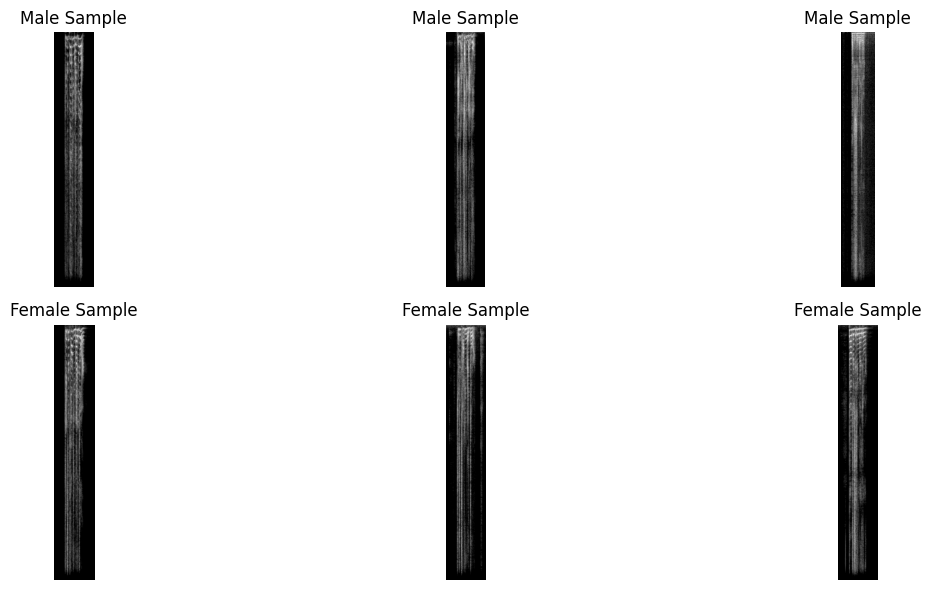

In [29]:
import random

n_samples = 3  # number of random samples per group

male_sample_paths = train_male['filepath'].tolist()
female_sample_paths = train_female['filepath'].tolist()

male_random_paths = random.sample(male_sample_paths, min(n_samples, len(male_sample_paths)))
female_random_paths = random.sample(female_sample_paths, min(n_samples, len(female_sample_paths)))

plt.figure(figsize=(15, 6))
for i, path in enumerate(male_random_paths):
    try:
        img = generate_spectrogram_image(path, sample_rate=22050)
        plt.subplot(2, n_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title("Male Sample")
        plt.axis('off')
    except Exception:
        continue

for i, path in enumerate(female_random_paths):
    try:
        img = generate_spectrogram_image(path, sample_rate=22050)
        plt.subplot(2, n_samples, n_samples+i+1)
        plt.imshow(img, cmap='gray')
        plt.title("Female Sample")
        plt.axis('off')
    except Exception:
        continue
plt.tight_layout()
plt.show()


##### Train 3 Models and Cross-Test Them

Model 1: Train on the entire dataset, test on all samples.

Model 2: Train on male samples; test on male samples and also on female samples.

Model 3: Train on female samples; test on female samples and also on male samples.

All-trained_All-test Param Combinations:   0%|          | 0/1 [00:00<?, ?it/s]

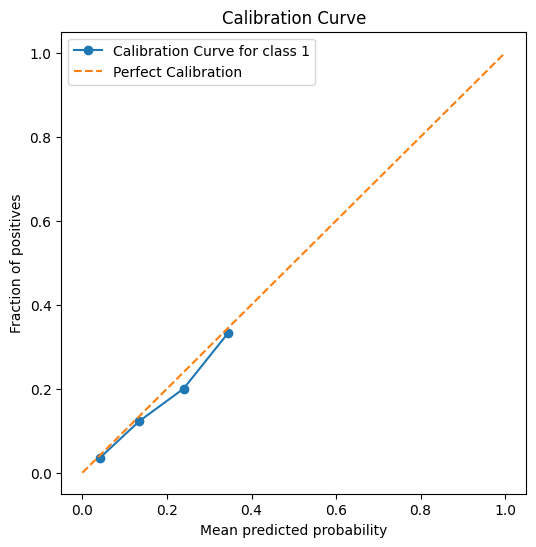

All-trained_Male-test Param Combinations:   0%|          | 0/1 [00:00<?, ?it/s]

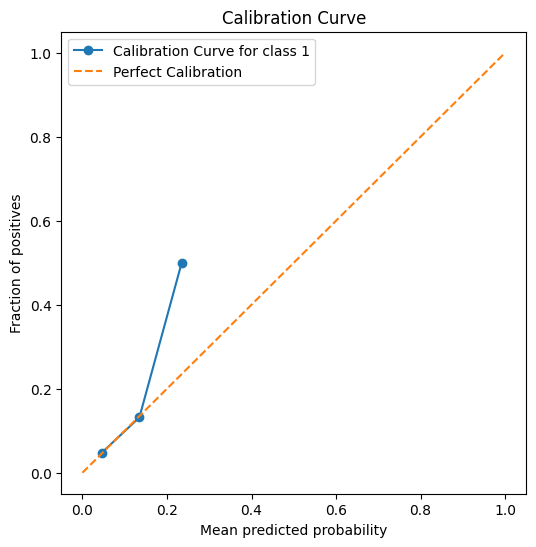

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

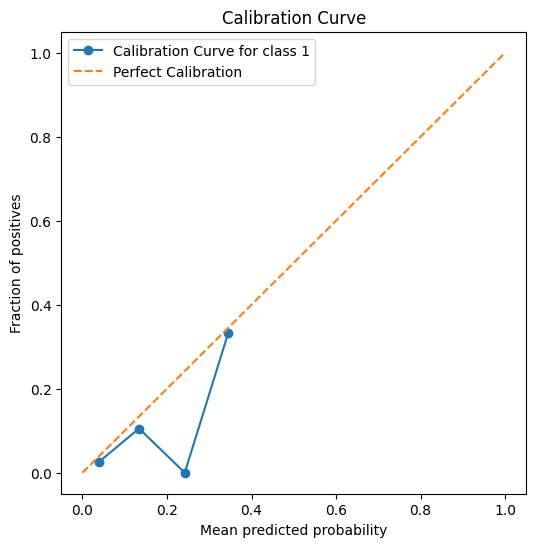

Male-trained_All-test Param Combinations:   0%|          | 0/1 [00:00<?, ?it/s]

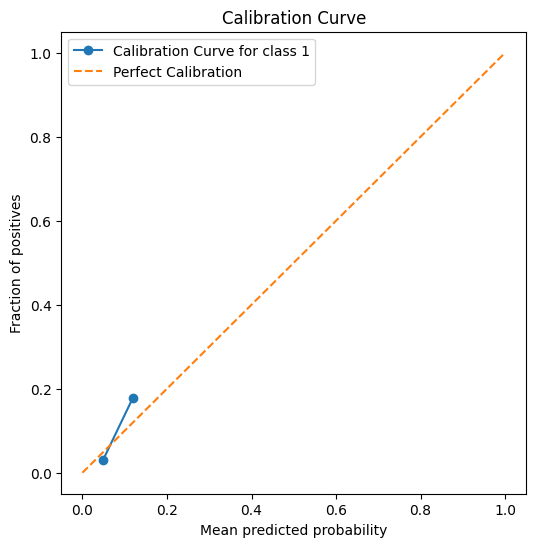

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

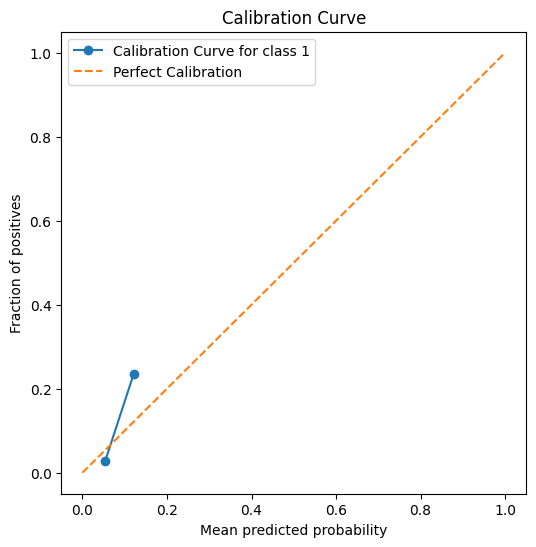

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

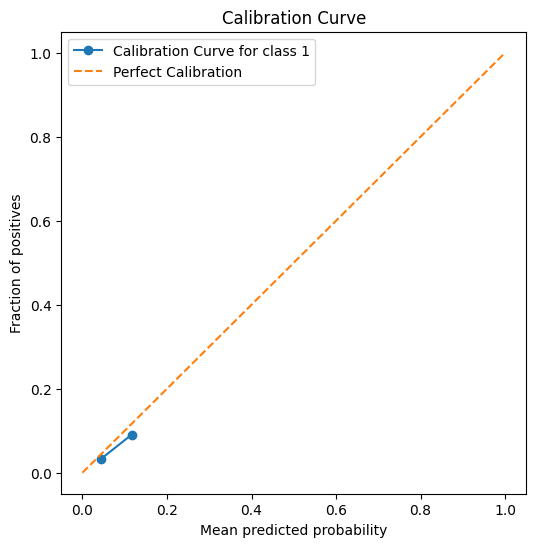

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

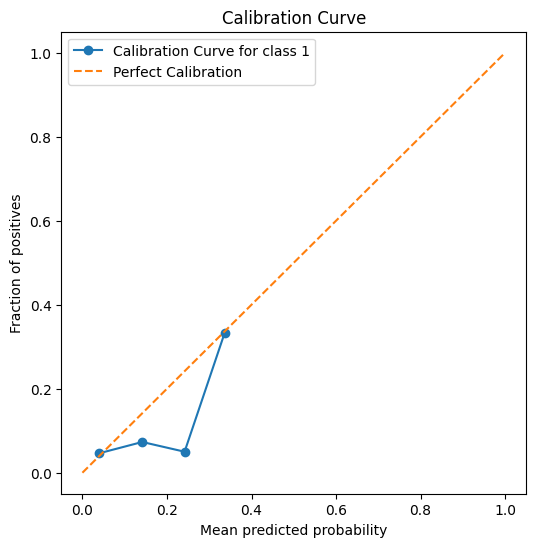

Female-trained_Male-test Param Combinations:   0%|          | 0/1 [00:00<?, ?it/s]

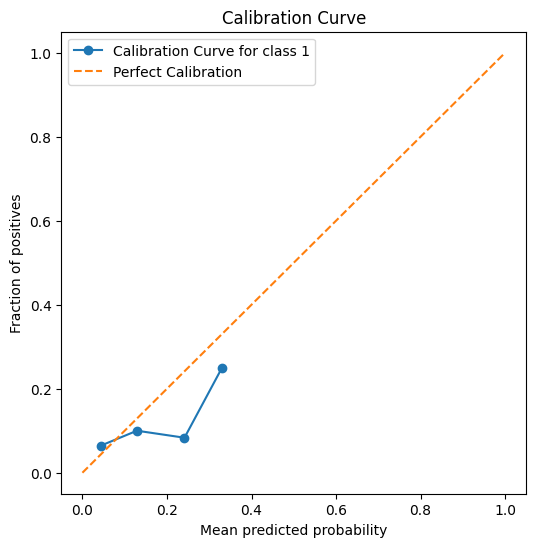

Female-trained_Female-test Param Combinations:   0%|          | 0/1 [00:00<?, ?it/s]

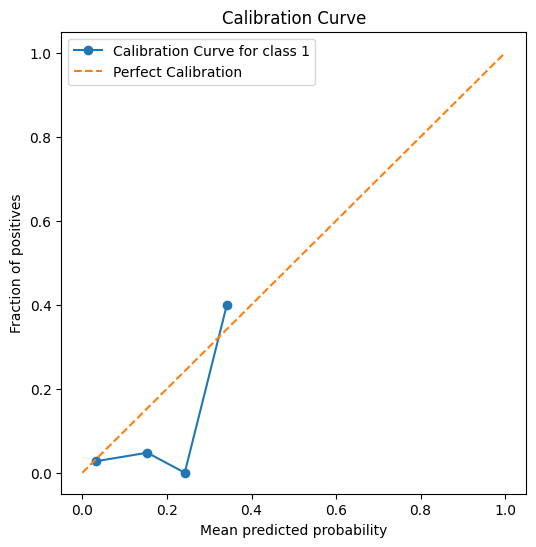

Female-trained_Female-test Param Combinations: 100%|██████████| 1/1 [00:32<00:00, 32.32s/it]


In [30]:
from sklearn.calibration import calibration_curve
import joblib

# Model 1: Full dataset
results_all_all = run_pipeline(train_df, test_df, classifiers, sample_rates, orb_features_list, cluster_numbers, label="All-trained_All-test")
results_all_male = run_pipeline(train_df, test_male, classifiers, sample_rates, orb_features_list, cluster_numbers, label="All-trained_Male-test")
results_all_female = run_pipeline(train_df, test_female, classifiers, sample_rates, orb_features_list, cluster_numbers, label="All-trained_Female-test")

# Model 2: Male-trained model tested on both male and female samples
results_male_all = run_pipeline(train_male, test_df, classifiers, sample_rates, orb_features_list, cluster_numbers, label="Male-trained_All-test")
results_male_male = run_pipeline(train_male, test_male, classifiers, sample_rates, orb_features_list, cluster_numbers, label="Male-trained_Male-test")
results_male_female = run_pipeline(train_male, test_female, classifiers, sample_rates, orb_features_list, cluster_numbers, label="Male-trained_Female-test")

# Model 3: Female-trained model tested on both female and male samples
results_female_all = run_pipeline(train_female, test_df, classifiers, sample_rates, orb_features_list, cluster_numbers, label="Female-trained_All-test")
results_female_male = run_pipeline(train_female, test_male, classifiers, sample_rates, orb_features_list, cluster_numbers, label="Female-trained_Male-test")
results_female_female = run_pipeline(train_female, test_female, classifiers, sample_rates, orb_features_list, cluster_numbers, label="Female-trained_Female-test")


##### Compare All Results

In [ ]:
# Combine all results into one list
all_results = results_full + results_male_male + results_male_female + results_female_female + results_female_male

# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(all_results)

results_df_sorted = results_df[["group", "cv_accuracy", "test_accuracy", "f1_score", "fpr", "fnr", "precision", "recall", "calibration_score"]]

# Display the first few rows of the sorted DataFrame
results_df_sorted.head()


,group,cv_accuracy,test_accuracy,f1_score,fpr,fnr,precision,recall,calibration_score
0,Full,None,0.361111,0.335312,0.092199,0.653055,0.347222,0.346945,0.097358
1,Male-trained_Male-test,None,0.376712,0.340986,0.090524,0.643727,0.340828,0.356273,0.096559
2,Male-trained_Female-test,None,0.267606,0.249744,0.105471,0.742315,0.287784,0.257685,0.104461
3,Female-trained_Female-test,None,0.359155,0.326195,0.092120,0.651173,0.321129,0.348827,0.093587
4,Female-trained_Male-test,None,0.321918,0.268283,0.097811,0.697619,0.290184,0.302381,0.103176


In [ ]:
all_results

[{'group': 'Full',
  'classifier': 'SVM',
  'sample_rate': 22050,
  'orb_features': 500,
  'n_clusters': 40,
  'model_file': 'svm_model_22050_500_40.pkl',
  'cv_accuracy': None,
  'test_accuracy': 0.3611111111111111,
  'f1_score': 0.33531164370052224,
  'fpr': np.float64(0.09219893620172417),
  'fnr': np.float64(0.6530549916188214),
  'precision': 0.3472220733754867,
  'recall': 0.3469450083811786,
  'calibration_score': np.float64(0.09735753600774204),
  'predicted_distribution': {8: np.float64(0.19791666666666666),
   2: np.float64(0.15625),
   6: np.float64(0.14930555555555555),
   3: np.float64(0.14583333333333334),
   7: np.float64(0.125),
   4: np.float64(0.1076388888888889),
   5: np.float64(0.10416666666666667),
   1: np.float64(0.013888888888888888)},
  'true_distribution': {3: np.float64(0.16319444444444445),
   4: np.float64(0.14583333333333334),
   2: np.float64(0.13541666666666666),
   6: np.float64(0.1284722222222222),
   8: np.float64(0.1284722222222222),
   5: np.float6

##### Generate the calibration curve

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# --- Calibration Curve & Score Calculation ---
# For demonstration, we assume a binary classification task.
# Ensure that your SVC (or other estimator) is configured with probability=True.

# Here, we use the last fitted GridSearchCV (grid) as an example.
# If you want to compute calibration for a specific group, set test_labels and test_scaled accordingly.

# Get predicted probabilities for the positive class (index 1)
probs = grid.predict_proba(test_scaled)[:, 1]

# Compute calibration curve data using 10 bins
fraction_of_positives, mean_predicted_value = calibration_curve(test_labels_processed, probs, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(8,6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibration curve")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()

# Compute the Brier score loss as the calibration score
brier = brier_score_loss(test_labels_processed, probs)
print("Brier score loss (Calibration Score):", brier)


NameError: name 'grid' is not defined

In [ ]:
import os
import numpy as np
import cv2
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             f1_score, precision_score, recall_score)
from sklearn.svm import SVC
from itertools import product
from tqdm import tqdm

####################################
# Helper Functions (Feature Engineering)
####################################

def generate_spectrogram_image(audio_path, sample_rate):
    y, sr = librosa.load(audio_path, sr=sample_rate)
    S = np.abs(librosa.stft(y))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    img = 255 * (S_db - S_db.min()) / (S_db.max() - S_db.min())
    return img.astype(np.uint8)

def extract_orb_descriptors(image, orb_detector):
    keypoints, descriptors = orb_detector.detectAndCompute(image, None)
    return descriptors

def build_codebook(descriptor_list, n_clusters):
    descriptors = np.vstack(descriptor_list)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(descriptors)
    return kmeans

def compute_bovw_histogram(descriptors, kmeans, n_clusters):
    if descriptors is None:
        return np.zeros(n_clusters)
    cluster_indices = kmeans.predict(descriptors)
    hist, _ = np.histogram(cluster_indices, bins=np.arange(n_clusters+1))
    if hist.sum() > 0:
        hist = hist / hist.sum()  # L1 normalization
    return hist

####################################
# Main BoVW + Classification Pipeline Function
####################################

def run_pipeline(train_df, test_df, classifiers, sample_rates, orb_features_list, cluster_numbers, label="All"):
    results = []
    # Only one combination will exist given our fixed parameter lists.
    param_combinations = list(product(sample_rates, orb_features_list, cluster_numbers))

    for sample_rate, orb_n_features, n_clusters in tqdm(param_combinations, total=len(param_combinations), desc=f"{label} Param Combinations"):
        orb = cv2.ORB_create(nfeatures=orb_n_features)

        train_descriptor_list = []
        train_descriptors_per_file = []
        train_labels_processed = []

        for _, row in train_df.iterrows():
            audio_path = row['filepath']
            if not os.path.exists(audio_path):
                continue
            try:
                spec_img = generate_spectrogram_image(audio_path, sample_rate)
                descriptors = extract_orb_descriptors(spec_img, orb)
                if descriptors is not None and len(descriptors) > 0:
                    train_descriptor_list.append(descriptors)
                train_descriptors_per_file.append(descriptors)
                train_labels_processed.append(row['emotion'])
            except Exception:
                continue

        if len(train_descriptor_list) == 0:
            continue

        try:
            kmeans = build_codebook(train_descriptor_list, n_clusters)
        except Exception:
            continue

        train_histograms = [compute_bovw_histogram(d, kmeans, n_clusters) for d in train_descriptors_per_file]
        train_histograms = np.array(train_histograms)
        train_labels_processed = np.array(train_labels_processed)

        # Process the test set
        test_histograms = []
        test_labels_processed = []
        for _, row in test_df.iterrows():
            audio_path = row['filepath']
            if not os.path.exists(audio_path):
                continue
            try:
                spec_img = generate_spectrogram_image(audio_path, sample_rate)
                descriptors = extract_orb_descriptors(spec_img, orb)
                hist = compute_bovw_histogram(descriptors, kmeans, n_clusters)
                test_histograms.append(hist)
                test_labels_processed.append(row['emotion'])
            except Exception:
                continue

        test_histograms = np.array(test_histograms)
        test_labels_processed = np.array(test_labels_processed)

        scaler = StandardScaler()
        train_scaled = scaler.fit_transform(train_histograms)
        test_scaled = scaler.transform(test_histograms)

        for clf_name, clf_info in classifiers.items():
            estimator = clf_info['estimator']
            param_grid = clf_info['param_grid']
            grid = GridSearchCV(estimator, param_grid, cv=3, scoring='accuracy')
            try:
                grid.fit(train_scaled, train_labels_processed)
            except Exception:
                continue

            preds = grid.predict(test_scaled)

            # Compute additional metrics:
            cm = confusion_matrix(test_labels_processed, preds)
            classes = np.unique(np.concatenate([test_labels_processed, preds]))
            fpr_list = []
            fnr_list = []
            for i, cls in enumerate(classes):
                TP = cm[i, i]
                FP = cm[:, i].sum() - TP
                FN = cm[i, :].sum() - TP
                TN = cm.sum() - (TP + FP + FN)
                fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
                fnr = FN / (TP + FN) if (TP + FN) > 0 else 0
                fpr_list.append(fpr)
                fnr_list.append(fnr)
            macro_fpr = np.mean(fpr_list)
            macro_fnr = np.mean(fnr_list)
            macro_f1 = f1_score(test_labels_processed, preds, average='macro')
            macro_precision = precision_score(test_labels_processed, preds, average='macro')
            macro_recall = recall_score(test_labels_processed, preds, average='macro')

            # Save predicted and true label distributions (to compute fairness metrics later)
            pred_distribution = dict(pd.Series(preds).value_counts(normalize=True))
            true_distribution = dict(pd.Series(test_labels_processed).value_counts(normalize=True))

            results.append({
                "group": label,
                "classifier": clf_name,
                "sample_rate": sample_rate,
                "orb_features": orb_n_features,
                "n_clusters": n_clusters,
                "best_params": grid.best_params_,
                "cv_accuracy": grid.best_score_,
                "test_accuracy": accuracy_score(test_labels_processed, preds),
                "f1_score": macro_f1,
                "fpr": macro_fpr,
                "fnr": macro_fnr,
                "precision": macro_precision,
                "recall": macro_recall,
                "predicted_distribution": pred_distribution,
                "true_distribution": true_distribution,
                "report": classification_report(test_labels_processed, preds, output_dict=True)
            })

    return results

####################################
# Classifier Configuration (Only SVM)
####################################

classifiers = {
    'SVM': {
        'estimator': SVC(random_state=89),
        'param_grid': {'C': [1], 'kernel': ['rbf'], 'probability': [True]}
    }
}

# Set parameters as requested
sample_rates = [22050]
orb_features_list = [500]
cluster_numbers = [40]

####################################
# Load Data and Split by Gender
####################################

train_df = pd.read_csv("train_labels.csv")
test_df = pd.read_csv("test_labels.csv")

# Overall data is used as-is.
# Also split by gender:
train_male = train_df[train_df['gender'] == 'Male']
test_male = test_df[test_df['gender'] == 'Male']

train_female = train_df[train_df['gender'] == 'Female']
test_female = test_df[test_df['gender'] == 'Female']

####################################
# Run Experiments for Each Group Separately
####################################

results_all = run_pipeline(train_df, test_df, classifiers, sample_rates, orb_features_list, cluster_numbers, label="All")
results_male = run_pipeline(train_male, test_male, classifiers, sample_rates, orb_features_list, cluster_numbers, label="Male")
results_female = run_pipeline(train_female, test_female, classifiers, sample_rates, orb_features_list, cluster_numbers, label="Female")

####################################
# Combine and Compare Results
####################################

all_results = results_all + results_male + results_female
results_df = pd.DataFrame(all_results)
results_df_sorted = results_df.sort_values(by=["group", "test_accuracy"], ascending=[True, False])

print("Performance Comparison by Group:")
print(results_df_sorted[["group", "classifier", "test_accuracy", "cv_accuracy", "f1_score", "fpr", "fnr",
                          "precision", "recall", "sample_rate", "orb_features", "n_clusters", "best_params"]])

####################################
# Fairness Metrics Between Male and Female Groups
####################################

# Compute mean metrics for male and female groups (assuming one SVM configuration per group)
male_results = results_df[results_df['group'] == 'Male']
female_results = results_df[results_df['group'] == 'Female']

if len(male_results) > 0 and len(female_results) > 0:
    male_recall = male_results['recall'].mean()
    female_recall = female_results['recall'].mean()
    male_precision = male_results['precision'].mean()
    female_precision = female_results['precision'].mean()
    male_fpr = male_results['fpr'].mean()
    female_fpr = female_results['fpr'].mean()
    male_f1 = male_results['f1_score'].mean()
    female_f1 = female_results['f1_score'].mean()

    # Fairness metrics:
    equal_opportunity_diff = male_recall - female_recall  # Difference in true positive rates
    equalized_odds_diff = ((male_recall - female_recall) + (male_fpr - female_fpr)) / 2  # Average difference of TPR and FPR
    predictive_parity_diff = male_precision - female_precision  # Difference in precision
    f1_score_diff = male_f1 - female_f1  # Difference in F1 score

    print("\nFairness Metrics (Male - Female):")
    print(f"Equal Opportunity Difference (Recall): {equal_opportunity_diff:.4f}")
    print(f"Equalized Odds Difference (Avg of TPR and FPR differences): {equalized_odds_diff:.4f}")
    print(f"Predictive Parity Difference (Precision): {predictive_parity_diff:.4f}")
    print(f"F1 Score Difference: {f1_score_diff:.4f}")
else:
    print("Insufficient data for fairness analysis between male and female groups.")

####################################
# Optional: Visualize Comparison
####################################

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df_sorted, x="group", y="test_accuracy", hue="classifier")
plt.title("Test Accuracy Comparison by Group and Classifier")
plt.ylabel("Test Accuracy")
plt.xlabel("Data Group")
plt.ylim(0, 1)
plt.legend(title="Classifier")
plt.tight_layout()
plt.show()


### Fairness Metrics Explanation

Below are explanations for each fairness metric difference calculated (Male - Female):

#### Equal Opportunity Difference (Recall: 0.0229)
- **What It Measures:**  
  Recall (or True Positive Rate) is the proportion of actual positive cases that the model correctly identifies.
- **Interpretation:**  
  A difference of **0.0229** means that, on average, the model correctly identifies about 2.29 percentage points more positive cases in the male group than in the female group. This indicates a slight advantage for males in detecting true positives.

#### Equalized Odds Difference (Avg of TPR and FPR differences: 0.0098)
- **What It Measures:**  
  Equalized Odds considers both the True Positive Rate (TPR) and False Positive Rate (FPR) by averaging the differences between groups.
- **Interpretation:**  
  A difference of **0.0098** suggests that the average gap in error rates (both TPR and FPR) between the male and female groups is very small (approximately 0.98 percentage points). This indicates that the model's overall error behavior is nearly similar for both genders.

#### Predictive Parity Difference (Precision: -0.0499)
- **What It Measures:**  
  Precision is the proportion of positive predictions that are correct.
- **Interpretation:**  
  A difference of **-0.0499** indicates that the precision for males is about 4.99 percentage points lower than for females. In other words, when the model predicts a positive outcome for males, it is slightly less reliable compared to females.

#### F1 Score Difference (0.0074)
- **What It Measures:**  
  The F1 score is the harmonic mean of precision and recall, balancing both metrics.
- **Interpretation:**  
  A difference of **0.0074** means that the overall balance between precision and recall (i.e., the F1 score) is almost identical between males and females, with the male group scoring only about 0.74 percentage points higher.

#### Summary
- **Equal Opportunity Difference:** Males have a slight advantage in correctly identifying positives.
- **Equalized Odds Difference:** The average error rates (TPR and FPR) are nearly balanced between genders.
- **Predictive Parity Difference:** The model is slightly less precise for male predictions compared to female predictions.
- **F1 Score Difference:** Overall performance, as measured by the F1 score, is very similar between the groups.
